In [ ]:
# default_exp classification.data.datasets

In [ ]:
# hide
import warnings

warnings.filterwarnings("ignore")
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.showdoc import *
from nbdev.export import *
from nbdev.imports import Config as NbdevConfig

data_path = str(NbdevConfig().path("nbs_path") / "data")
nbdev_path = data_path
data_path

'/Users/ayushman/Desktop/lightning_cv/nbs/data'

<IPython.core.display.Javascript object>

# Datasets
> Helper functions to get data in a `Dataset` s for `ImageClassification`

In [ ]:
# export
import os
import abc
from typing import *
import pandas as pd
from omegaconf import DictConfig
from fastcore.all import store_attr, ifnone, delegates, Path

import torch
from torch.utils.data import Dataset
from torchvision.datasets.folder import make_dataset

from lightning_cv.core.utils.data import IMG_EXTENSIONS
from lightning_cv.core import default_logger, _DatasetCatalog, LOADER_REGISTERY
from lightning_cv.classification.data.transforms import (
    ImageClassificationTransforms,
    create_transform,
    TransformOutput,
)

logger = default_logger()

<IPython.core.display.Javascript object>

In [ ]:
# hide
from lightning_cv.core.utils.data import download_data, Urls, folder2df

download_data(Urls.DOGS)
data_path = Path(f"{data_path}/cats_and_dogs_filtered/train")

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/12 21:47:33 lcv.core.utils.data]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


<IPython.core.display.Javascript object>

In [ ]:
# hide
data_path.ls()

(#3) [Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs'),Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats'),Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/train.csv')]

<IPython.core.display.Javascript object>

In [ ]:
# export
class BaseClassificationDataset(Dataset):
    "Base class for ImageClassification Dataset"

    def __init__(self, cfg: DictConfig):
        super(BaseClassificationDataset, self).__init__()
        # instantiate transformations from cfg
        obj: TransformOutput = create_transform(cfg)
        self._transforms = obj.TRANSFORMS
        self.loader = obj.LOADER

    @property
    def transforms(self):
        return self._transforms

    @transforms.setter
    def transforms(self, x: ImageClassificationTransforms):
        self._transforms = x

    @abc.abstractmethod
    def __getitem__(self, x):
        raise NotImplementedError

    @abc.abstractmethod
    def __len__(self, x):
        raise NotImplementedError

<IPython.core.display.Javascript object>

In [ ]:
# export
class ImageFolderDataset(BaseClassificationDataset):
    "Create `Dataset` instance from `source` using `transforms`"

    def __init__(
        self,
        source: Union[str, Path],
        cfg: DictConfig,
        classes: Dict = None,
        test: bool = False,
    ):

        store_attr("source, test")

        if not self.test:
            self.classes = ifnone(classes, self._find_classes(self.source))
            samples = make_dataset(self.source, self.classes, IMG_EXTENSIONS, None)
            self.images = [s[0] for s in samples]
            self.targets = [s[1] for s in samples]
            logger.info(
                f"Found {len(self.images)} files belonging to {len(set(self.targets))} classes."
            )

        if self.test:
            samples = self.make_test(source)
            self.images = samples
            logger.info(f"Found {len(self.images)} files.")

        super(ImageFolderDataset, self).__init__(cfg=cfg)

    def _find_classes(self, dir: str) -> Tuple[List[str], Dict[str, int]]:
        "Finds the class folders in the dataset"
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return class_to_idx

    @staticmethod
    def has_file_allowed_extension(filename: str, extensions: Tuple[str, ...]) -> bool:
        """
        Checks if a file is an allowed extension.
        Args:
            filename (string): path to a file
            extensions (tuple of strings): extensions to consider (lowercase)
        Returns:
            bool: True if the filename ends with one of given extensions

        From : https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
        """
        return filename.lower().endswith(extensions)

    @staticmethod
    def is_valid_file(x: str) -> bool:
        return ImageFolderDataset.has_file_allowed_extension(
            x, cast(Tuple[str, ...], IMG_EXTENSIONS)
        )

    @staticmethod
    def make_test(root: str):
        instances = []
        is_valid_file = cast(Callable[[str], bool], ImageFolderDataset.is_valid_file)
        for fname in os.listdir(root):
            path = os.path.join(root, fname)
            if is_valid_file(path):
                instances.append(path)
        return instances

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = self.loader(image)
        aug_im = self.transforms(image)

        if self.test:
            return aug_im
        else:
            label = self.targets[index]
            return aug_im, torch.tensor(label, dtype=torch.long)

<IPython.core.display.Javascript object>

Required arguments :
- **`source`: `Union[str, Path]`** - Source directory of the Images
- **`cfg`: `DictConfig`** - `TRANSFORMS.{TRAIN/VALID}` instance of `lightning_cv.config.get_cfg`

You can optinally pass in **`classes`**, which should be a `Dict` that contains a mapping of `{class_name: interger_label}` and **`test`** ; if not `test`, `target`s are not returned, only images are returned after applying `tfm`

Images should arranged in this way:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

In [ ]:
from lightning_cv.config import get_cfg
from lightning_cv.core.utils.common import imshow_tensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from omegaconf import OmegaConf

cfg = get_cfg()

<IPython.core.display.Javascript object>

INFO [03/12 21:47:47 __main__]: Transformations used : LOADER: pil_loader
NAME: GenericImageTransform
ARGUMENTS:
  img_size: 224
  interpolation: random
  hflip: 0.5
  vflip: 0.5
  color_jitter: 0.4
  re_prob: 0.5
  re_mode: pixel
  re_count: 1
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225

INFO [03/12 21:47:47 __main__]: Found 2000 files belonging to 2 classes.


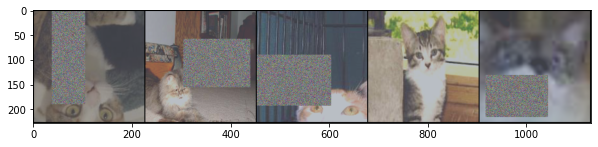

<IPython.core.display.Javascript object>

In [ ]:
logger.info(f"Transformations used : {OmegaConf.to_yaml(cfg.TRANSFORMS.TRAIN)}")
ds = ImageFolderDataset(source=data_path, test=False, cfg=cfg.TRANSFORMS.TRAIN)
dl = DataLoader(ds, batch_size=5, shuffle=True)

# since test is False both images and targets are returned
image, target = next(iter(dl))
plt.figure(figsize=(10, 10))
imshow_tensor(image, normalize=True)

Transformations can also be changed after instantiating the `Dataset` class.

INFO [03/12 21:47:53 __main__]: Transformations used : LOADER: pil_loader
NAME: ImagenetNoAugmentTransform
ARGUMENTS:
  img_size: 224
  interpolation: bilinear
  mean:
  - 0.485
  - 0.456
  - 0.406
  std:
  - 0.229
  - 0.224
  - 0.225



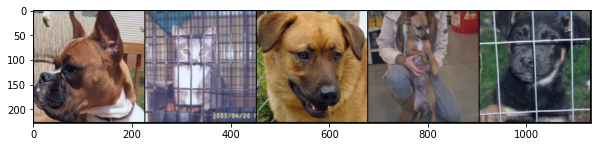

<IPython.core.display.Javascript object>

In [ ]:
transforms = create_transform(cfg.TRANSFORMS.VALID)
logger.info(f"Transformations used : {OmegaConf.to_yaml(cfg.TRANSFORMS.VALID)}")
ds.transforms = transforms.TRANSFORMS

plt.figure(figsize=(10, 10))
image, target = next(iter(dl))
imshow_tensor(image, normalize=True)

As we can see here the `transformations` have been changed .

> Note: We cannot chain transformations from both `torchvision` and `albumentations`. The `loader` required for the transformations should be same.

Generating a Test Dataset (Dataset without test labels) : 

INFO [03/12 21:47:57 __main__]: Found 1000 files.


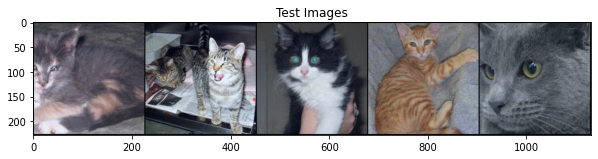

<IPython.core.display.Javascript object>

In [ ]:
ds = ImageFolderDataset(
    source=os.path.join(data_path, "cats"), cfg=cfg.TRANSFORMS.VALID, test=True
)

dl = DataLoader(ds, batch_size=5, shuffle=True)

# since test is True only images are returned
image = next(iter(dl))
plt.figure(figsize=(10, 10))
imshow_tensor(image, title="Test Images", normalize=True)

In [ ]:
# export
class ImageCsvDataset(BaseClassificationDataset):
    "Create `Dataset` instance from `csv` using `transforms`, `image_col` and `label_col`"

    @delegates(pd.read_csv)
    def __init__(
        self,
        csv: str,
        image_col: str,
        cfg: DictConfig,
        label_col: Optional[str] = None,
        test: bool = False,
        **kwargs
    ):

        store_attr("label_col, image_col, test")
        self.df = pd.read_csv(csv, **kwargs)
        super(ImageCsvDataset, self).__init__(cfg=cfg)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image = self.df[self.image_col][index]
        image = self.loader(image)
        aug_im = self.transforms(image)

        if self.test:
            return aug_im
        if not self.test:
            label = self.df[self.label_col][index]
            label = torch.tensor(label, dtype=torch.long)
            return aug_im, label

<IPython.core.display.Javascript object>

Arguments:
- **`csv (str)`**: path to the csv file.
- **`cfg (DictConfig)`** - `TRANSFORMS.{TRAIN/VALID}` instance of `lightning_cv.config.get_cfg`
- **`label_col (Optional[str])`**: name of the column where the labels for the images are stored.
- **`loader (str)`**: item in `Loaders` registery for reading the Images.
- **`test (bool)`**: if test , then only images are returned and `label_col` is skipped.
- **`kwargs`** : extra arguments to pass into `pd.read_csv`

Here is how to load a dataset using the class:

Let's grab a random csv dataset -

Here we will use the func `folder2df` to create a csv file from the existing Urls.DOOGS dataset

In [ ]:
from lightning_cv.core.utils.data import folder2df

pd.set_option("display.max_colwidth", None)

logger.info(f"Data path: {data_path}")

df = folder2df(data_path, extension=IMG_EXTENSIONS, shuffle=True)


def _map_fn(name):
    return 0 if name == "cats" else 1


df["label"] = df["target"].map(_map_fn)
df.to_csv(f"{data_path}/train.csv", index=False)

df.head()

INFO [03/12 21:47:59 __main__]: Data path: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train
INFO [03/12 21:47:59 lcv.core.utils.data]: Found 2000 files belonging to 2 classes.


,image_id,target,label
0,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.777.jpg,cats,0
1,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.317.jpg,cats,0
2,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.117.jpg,cats,0
3,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/dogs/dog.646.jpg,dogs,1
4,/Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered/train/cats/cat.514.jpg,cats,0


<IPython.core.display.Javascript object>

Let's create `Dataset` s and `DataLoader`s from the above csv file.

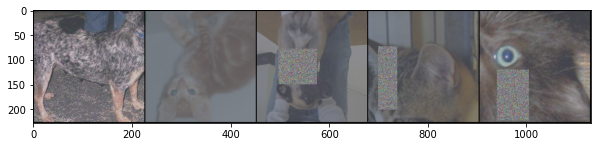

<IPython.core.display.Javascript object>

In [ ]:
cfg = get_cfg()
csv = f"{data_path}/train.csv"

ds = ImageCsvDataset(
    csv, image_col="image_id", label_col="label", cfg=cfg.TRANSFORMS.TRAIN
)

dl = DataLoader(ds, batch_size=5, shuffle=True)
image, target = next(iter(dl))

plt.figure(figsize=(10, 10))
imshow_tensor(image, normalize=True)

For the test dataset -

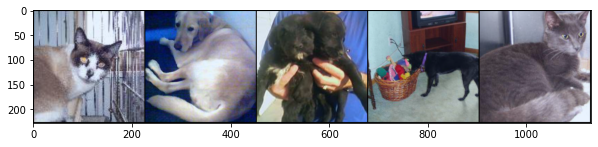

<IPython.core.display.Javascript object>

In [ ]:
csv = f"{data_path}/train.csv"

ds = ImageCsvDataset(
    csv, image_col="image_id", label_col="label", cfg=cfg.TRANSFORMS.VALID, test=True
)

dl = DataLoader(ds, batch_size=5, shuffle=True)

image = next(iter(dl))

plt.figure(figsize=(10, 10))
imshow_tensor(image, normalize=True)

## ClassificationDatasetCatalog
> A `_DatasetCatalog` instance for ImageClassification Datasets.

In [ ]:
# export
ClassificationDatasetCatalog = _DatasetCatalog()
ClassificationDatasetCatalog.__doc__ = (
    _DatasetCatalog.__doc__
    + """
    Methods:  
    `lightning_cv.classification.data.datasets.ClassificationDatasetCatalog.register` 
    `lightning_cv.classification.data.datasets.ClassificationDatasetCatalog.get`
"""
)

<IPython.core.display.Javascript object>

In [ ]:
show_doc(ClassificationDatasetCatalog)

<h4 id="DatasetCatalog(registered datasets: )" class="doc_header"><code>DatasetCatalog(registered datasets: )</code><a href="" class="source_link" style="float:right">[source]</a></h4>

A global dictionary that stores information about the datasets and how to obtain them.
It contains a mapping from strings
(which are names that identify a dataset, e.g. "my_dataset_train")
to a function which parses the instanitiates the `Dataset` obj.

From - https://github.com/facebookresearch/detectron2/blob/master/detectron2/data/catalog.py

Methods:  
`lightning_cv.classification.data.datasets.ClassificationDatasetCatalog.register` 
`lightning_cv.classification.data.datasets.ClassificationDatasetCatalog.get`

<IPython.core.display.Javascript object>

In [ ]:
# export
class ClassificationDatasetOutput(NamedTuple):
    "Tuple for storing TRAIN and VALID datasets generated from `create_dataset`"
    TRAIN: Union[BaseClassificationDataset, Dataset] = None
    VALID: Union[BaseClassificationDataset, Dataset, None] = None

<IPython.core.display.Javascript object>

In [ ]:
# export
def create_dataset(cfg: DictConfig) -> ClassificationDatasetOutput:
    """
    Retrive a `BaseClassificationDataset` instance from ImageClassificationDatasetCatalog.

    > Note: This function retrives both the train and valid datasets from config. Ideally you want want both
    train and validation datsets but if you do not have a validation dataset, then set
    `DATASETS.VALID = None`
    """
    train_ds = ClassificationDatasetCatalog.get(
        cfg.DATASETS.TRAIN, cfg=cfg.TRANSFORMS.TRAIN
    )

    if cfg.DATASETS.VALID is not None or cfg.DATASETS.VALID != " ":
        valid_ds = ClassificationDatasetCatalog.get(
            cfg.DATASETS.VALID, cfg=cfg.TRANSFORMS.VALID
        )
    else:
        logger.warning("Validation Dataset not specified !")
        valid_ds = None

    return ClassificationDatasetOutput(TRAIN=train_ds, VALID=valid_ds)

<IPython.core.display.Javascript object>

> Important: For `create_dataset` to work the dataset must be a subclass of `BaseClassificationDataset` and must have a argument `cfg` which loads in the transformations and the loader.

Here an end to end example on how to create and register Datasets

In [ ]:
# download the datsets
download_data(Urls.BEES)

# prepare the data paths
path = Path(nbdev_path)
path = path / "hymenoptera_data"

train_path = path / "train"
valid_path = path / "val"

logger.info(f"Train Paths {train_path.ls()}")
logger.info(f"Valid Paths {valid_path.ls()}")

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/12 21:48:08 lcv.core.utils.data]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/12 21:48:08 __main__]: Train Paths [Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data/train/bees'), Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data/train/ants')]
INFO [03/12 21:48:08 __main__]: Valid Paths [Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data/val/bees'), Path('/Users/ayushman/Desktop/lightning_cv/nbs/data/hymenoptera_data/val/ants')]


<IPython.core.display.Javascript object>

In [ ]:
# imports
from functools import partial
import torchvision.transforms as T
from timm.data import RandomResizedCropAndInterpolation
from timm.data.random_erasing import RandomErasing

from lightning_cv.config import get_class_path
from lightning_cv.classification.data.transforms import ImageNetConstants

# grab the config
cfg = get_cfg()

# train and validation datasets
train_dataset = partial(ImageFolderDataset, source=train_path)
valid_dataset = partial(ImageFolderDataset, source=valid_path)

<IPython.core.display.Javascript object>

In [ ]:
# register datasets
ClassificationDatasetCatalog.register("My_train_dataset", train_dataset)
ClassificationDatasetCatalog.register("My_valid_dataset", valid_dataset)

<IPython.core.display.Javascript object>

In [ ]:
# update config
cfg.DATASETS.TRAIN = "My_train_dataset"
cfg.DATASETS.VALID = "My_valid_dataset"

# update transformations
cfg.TRANSFORMS.TRAIN.LOADER = "pil_loader"
cfg.TRANSFORMS.TRAIN.NAME = "TorchvisionTransform"
cfg.TRANSFORMS.TRAIN.ARGUMENTS = [
    dict(
        _target_=get_class_path(RandomResizedCropAndInterpolation),
        size=255,
        interpolation="random",
    ),
    dict(
        _target_=get_class_path(T.ColorJitter),
        brightness=0.4,
        contrast=0.4,
        saturation=0.4,
        hue=0,
    ),
    dict(_target_=get_class_path(T.RandomHorizontalFlip)),
    dict(_target_=get_class_path(T.ToTensor)),
    dict(
        _target_=get_class_path(T.Normalize),
        mean=ImageNetConstants.MEAN,
        std=ImageNetConstants.STD,
    ),
    dict(_target_=get_class_path(RandomErasing), device="cpu", mode="pixel"),
]


cfg.TRANSFORMS.VALID.LOADER = cfg.TRANSFORMS.TRAIN.LOADER
cfg.TRANSFORMS.VALID.NAME = "ImagenetNoAugmentTransform"
cfg.TRANSFORMS.ARGUMENTS = dict(
    img_size=(255, 255),
    crop_pct=ImageNetConstants.CROP,
    mean=ImageNetConstants.MEAN,
    std=ImageNetConstants.STD,
)

<IPython.core.display.Javascript object>

In [ ]:
# load in the datasets
datasets = create_dataset(cfg)

INFO [03/12 21:48:09 __main__]: Found 244 files belonging to 2 classes.
INFO [03/12 21:48:10 __main__]: Found 153 files belonging to 2 classes.


<IPython.core.display.Javascript object>

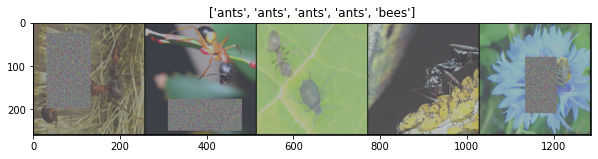

<IPython.core.display.Javascript object>

In [ ]:
# view train dataset images
dl = DataLoader(datasets.TRAIN, batch_size=5, shuffle=True)
label_dict = {v: k for k, v in datasets.TRAIN.classes.items()}

image, target = next(iter(dl))
target = target.data.numpy()

plt.figure(figsize=(10, 10))
imshow_tensor(image, title=[label_dict[item] for item in target], normalize=True)

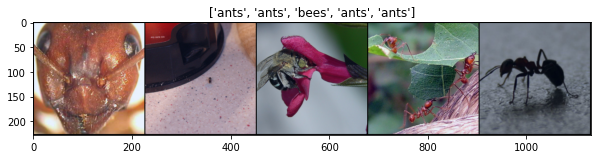

<IPython.core.display.Javascript object>

In [ ]:
# view valid dataset images
dl = DataLoader(datasets.VALID, batch_size=5, shuffle=True)
label_dict = {v: k for k, v in datasets.VALID.classes.items()}

image, target = next(iter(dl))
target = target.data.numpy()

plt.figure(figsize=(10, 10))
imshow_tensor(image, title=[label_dict[item] for item in target], normalize=True)

> Important: For the above workflow you work your `datasets` must be a function that returns an instance or subclass of `BaseClassificationDataset` Or you dataset should also contain a `cfg` parameter which takes in `lightning_cv` config.

In [ ]:
import torchvision

download_data(Urls.DOGS)
data_path = Path(f"{nbdev_path}/cats_and_dogs_filtered")

# create dataset loading functions
def my_dataset(cfg, stage="train"):
    tfm_dict = create_transform(cfg)
    if stage == "train":
        return torchvision.datasets.ImageFolder(
            data_path / "train", transform=tfm_dict.TRANSFORMS, loader=tfm_dict.LOADER
        )
    elif stage == "valid":
        return torchvision.datasets.ImageFolder(
            data_path / "train", transform=tfm_dict.TRANSFORMS, loader=tfm_dict.LOADER
        )

Using downloaded and verified file: /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip
Extracting /Users/ayushman/Desktop/lightning_cv/nbs/data/cats_and_dogs_filtered.zip to /Users/ayushman/Desktop/lightning_cv/nbs/data
INFO [03/12 21:48:13 lcv.core.utils.data]: Data downloaded to /Users/ayushman/Desktop/lightning_cv/nbs/data


<IPython.core.display.Javascript object>

> Note: Notice how in `my_dataset` we passed in the same cfg for both the train and validation datasets. This is beacause `create_dataset` func will automatically determine the transformations config for train and validation datasets. The name of the dataset passed to `cfg.DATSETS.TRAIN` will recive the train transformation and config and vice versa.

In [ ]:
# register dataset
ClassificationDatasetCatalog.register(
    "my_dogs_train", partial(my_dataset, stage="train")
)
ClassificationDatasetCatalog.register(
    "my_dogs_valid", partial(my_dataset, stage="valid")
)

<IPython.core.display.Javascript object>

In [ ]:
cfg = get_cfg()
cfg.DATASETS.TRAIN = "my_dogs_train"
cfg.DATASETS.VALID = "my_dogs_valid"

dsets = create_dataset(cfg)

<IPython.core.display.Javascript object>

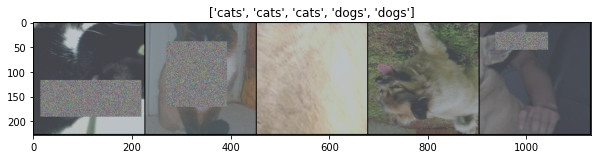

<IPython.core.display.Javascript object>

In [ ]:
dl = DataLoader(dsets.TRAIN, batch_size=5, shuffle=True)
label_dict = {v: k for k, v in dsets.TRAIN.class_to_idx.items()}

image, target = next(iter(dl))
target = target.data.numpy()

plt.figure(figsize=(10, 10))
imshow_tensor(image, title=[label_dict[item] for item in target], normalize=True)

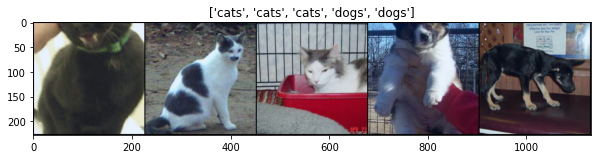

<IPython.core.display.Javascript object>

In [ ]:
# view valid dataset images
dl = DataLoader(dsets.VALID, batch_size=5, shuffle=True)
label_dict = {v: k for k, v in dsets.VALID.class_to_idx.items()}

image, target = next(iter(dl))
target = target.data.numpy()

plt.figure(figsize=(10, 10))
imshow_tensor(image, title=[label_dict[item] for item in target], normalize=True)

## Export -

In [ ]:
# hide
notebook2script()

Converted 00_config.ipynb.
Converted 00a_core.utils.common.ipynb.
Converted 00b_core.utils.data.ipynb.
Converted 00c_core.optim.ipynb.
Converted 00d_core.schedules.ipynb.
Converted 00e_core.layers.ipynb.
Converted 01a_classification.data.transforms.ipynb.
Converted 01b_classification.data.datasets.ipynb.
Converted 01c_classification.modelling.backbones.ipynb.
Converted 01d_classification.modelling.classifiers.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>